# Binary Retinal Vessel Segmentation on DRIVE Dataset



## Methods Used:
- Green channel extraction
- CLAHE (Contrast Limited Adaptive Histogram Equalization)
- Niblack adaptive thresholding
- Sauvola adaptive thresholding

## Evaluation Metrics:
- Sensitivity
- Accuracy
- F1 Score

In [1]:
!pip install opencv-python scikit-image matplotlib numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Libraries

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from typing import Tuple

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Define Metrics Computation Function

This function computes performance metrics including:
- **Sensitivity** (Recall): TP / (TP + FN)
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN)
- **F1 Score**: Harmonic mean of precision and sensitivity

In [12]:
def compute_metrics(pred: np.ndarray, gt: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute segmentation performance metrics.
    
    Args:
        pred: Binary prediction array
        gt: Ground truth binary array
    
    Returns:
        Tuple of (sensitivity, accuracy, f1_score)
    """
    TP = np.sum((pred == 1) & (gt == 1))
    TN = np.sum((pred == 0) & (gt == 0))
    FP = np.sum((pred == 1) & (gt == 0))
    FN = np.sum((pred == 0) & (gt == 1))

    sensitivity = TP / (TP + FN + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    f1 = 2 * precision * sensitivity / (precision + sensitivity + 1e-8)

    return sensitivity, accuracy, f1

## 4. Define Image Preprocessing Function

Preprocessing steps:
1. Extract green channel (retinal vessels are most visible in this channel)
2. Apply CLAHE to enhance contrast

In [13]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Preprocess retinal image: extract green channel and apply CLAHE.
    
    Args:
        image: RGB image array
    
    Returns:
        Enhanced green channel
    """
    # Extract green channel
    green_channel = image[:, :, 1]
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green_channel)
    
    return enhanced

## 5. Define Thresholding Function

Applies both Niblack and Sauvola adaptive thresholding methods:
- **Niblack**: Uses local mean and standard deviation
- **Sauvola**: Improved version of Niblack, better for documents and medical images

In [14]:
def apply_thresholding(enhanced: np.ndarray, window_size: int = 25, k: float = 0.2) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply Niblack and Sauvola thresholding methods.
    
    Args:
        enhanced: Enhanced grayscale image
        window_size: Local window size for adaptive thresholding
        k: Parameter for threshold calculation
    
    Returns:
        Tuple of (niblack_binary, sauvola_binary)
    """
    # Niblack thresholding
    thresh_niblack = threshold_niblack(enhanced, window_size, k=k)
    binary_niblack = enhanced > thresh_niblack

    # Sauvola thresholding
    thresh_sauvola = threshold_sauvola(enhanced, window_size, k=k)
    binary_sauvola = enhanced > thresh_sauvola

    return binary_niblack, binary_sauvola

## 6. Define Data Loading Function

Loads the following for each image:
- Original retinal image
- Manual annotation (ground truth)
- Field of view mask

In [15]:
def load_image_set(image_path: str, manual_path: str, mask_path: str, number: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Load image, ground truth, and mask for a given image number.
    
    Args:
        image_path: Path to images directory
        manual_path: Path to manual annotations directory
        mask_path: Path to masks directory
        number: Image number identifier
    
    Returns:
        Tuple of (image, ground_truth, mask)
    """
    # Construct file paths
    img_file = os.path.join(image_path, f"{number}_training.tif")
    manual_file = os.path.join(manual_path, f"{number}_manual1.gif")
    mask_file = os.path.join(mask_path, f"{number}_training_mask.gif")

    # Load image
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truth
    gt = cv2.imread(manual_file, 0)
    gt = gt > 0

    # Load mask
    mask = cv2.imread(mask_file, 0)
    mask = mask > 0

    return image, gt, mask

## 7. Process All Training Images

Main processing loop that:
1. Iterates through all images in the training set
2. Loads each image with its ground truth and mask
3. Applies preprocessing and thresholding
4. Computes metrics for both methods
5. Stores results for averaging

In [16]:
# Define paths
base_path = "DRIVE/training/"
image_path = os.path.join(base_path, "images")
manual_path = os.path.join(base_path, "1st_manual")
mask_path = os.path.join(base_path, "mask")

# Parameters
window_size = 25
k = 0.2

# Lists to store metrics
niblack_metrics = []
sauvola_metrics = []

# Get list of image files
image_files = sorted([f for f in os.listdir(image_path) if f.endswith(".tif")])

print(f"Processing {len(image_files)} images...\n")

# Process all training images
for i, file in enumerate(image_files, 1):
    # Extract image number
    number = file.split("_")[0]
    print(f"[{i}/{len(image_files)}] Processing image {number}...")

    # Load data
    image, gt, mask = load_image_set(image_path, manual_path, mask_path, number)

    # Preprocess
    enhanced = preprocess_image(image)

    # Apply thresholding
    binary_niblack, binary_sauvola = apply_thresholding(enhanced, window_size, k)

    # Apply mask to predictions and ground truth
    gt_masked = gt[mask]
    niblack_masked = binary_niblack[mask]
    sauvola_masked = binary_sauvola[mask]

    # Compute metrics
    niblack_metrics.append(compute_metrics(niblack_masked, gt_masked))
    sauvola_metrics.append(compute_metrics(sauvola_masked, gt_masked))

# Convert to numpy arrays
niblack_metrics = np.array(niblack_metrics)
sauvola_metrics = np.array(sauvola_metrics)

print("\nProcessing complete!")

Processing 20 images...

[1/20] Processing image 21...
[2/20] Processing image 22...
[3/20] Processing image 23...
[4/20] Processing image 24...
[5/20] Processing image 25...
[6/20] Processing image 26...
[7/20] Processing image 27...
[8/20] Processing image 28...
[9/20] Processing image 29...
[10/20] Processing image 30...
[11/20] Processing image 31...
[12/20] Processing image 32...
[13/20] Processing image 33...
[14/20] Processing image 34...
[15/20] Processing image 35...
[16/20] Processing image 36...
[17/20] Processing image 37...
[18/20] Processing image 38...
[19/20] Processing image 39...
[20/20] Processing image 40...

Processing complete!


## 8. Display Average Results

Compute and display average metrics across all training images for both methods.

In [17]:
print("=" * 50)
print("Average Results on Training Set")
print("=" * 50)

print("\nNIBLACK THRESHOLDING")
print("-" * 30)
print(f"Sensitivity: {np.mean(niblack_metrics[:, 0]):.4f}")
print(f"Accuracy:    {np.mean(niblack_metrics[:, 1]):.4f}")
print(f"F1 Score:    {np.mean(niblack_metrics[:, 2]):.4f}")

print("\nSAUVOLA THRESHOLDING")
print("-" * 30)
print(f"Sensitivity: {np.mean(sauvola_metrics[:, 0]):.4f}")
print(f"Accuracy:    {np.mean(sauvola_metrics[:, 1]):.4f}")
print(f"F1 Score:    {np.mean(sauvola_metrics[:, 2]):.4f}")

Average Results on Training Set

NIBLACK THRESHOLDING
------------------------------
Sensitivity: 0.1827
Accuracy:    0.2570
F1 Score:    0.0585

SAUVOLA THRESHOLDING
------------------------------
Sensitivity: 0.4604
Accuracy:    0.0830
F1 Score:    0.1122


## 9. Visualize Sample Results

Display the last processed image with:
- Original image
- Ground truth
- Niblack segmentation
- Sauvola segmentation

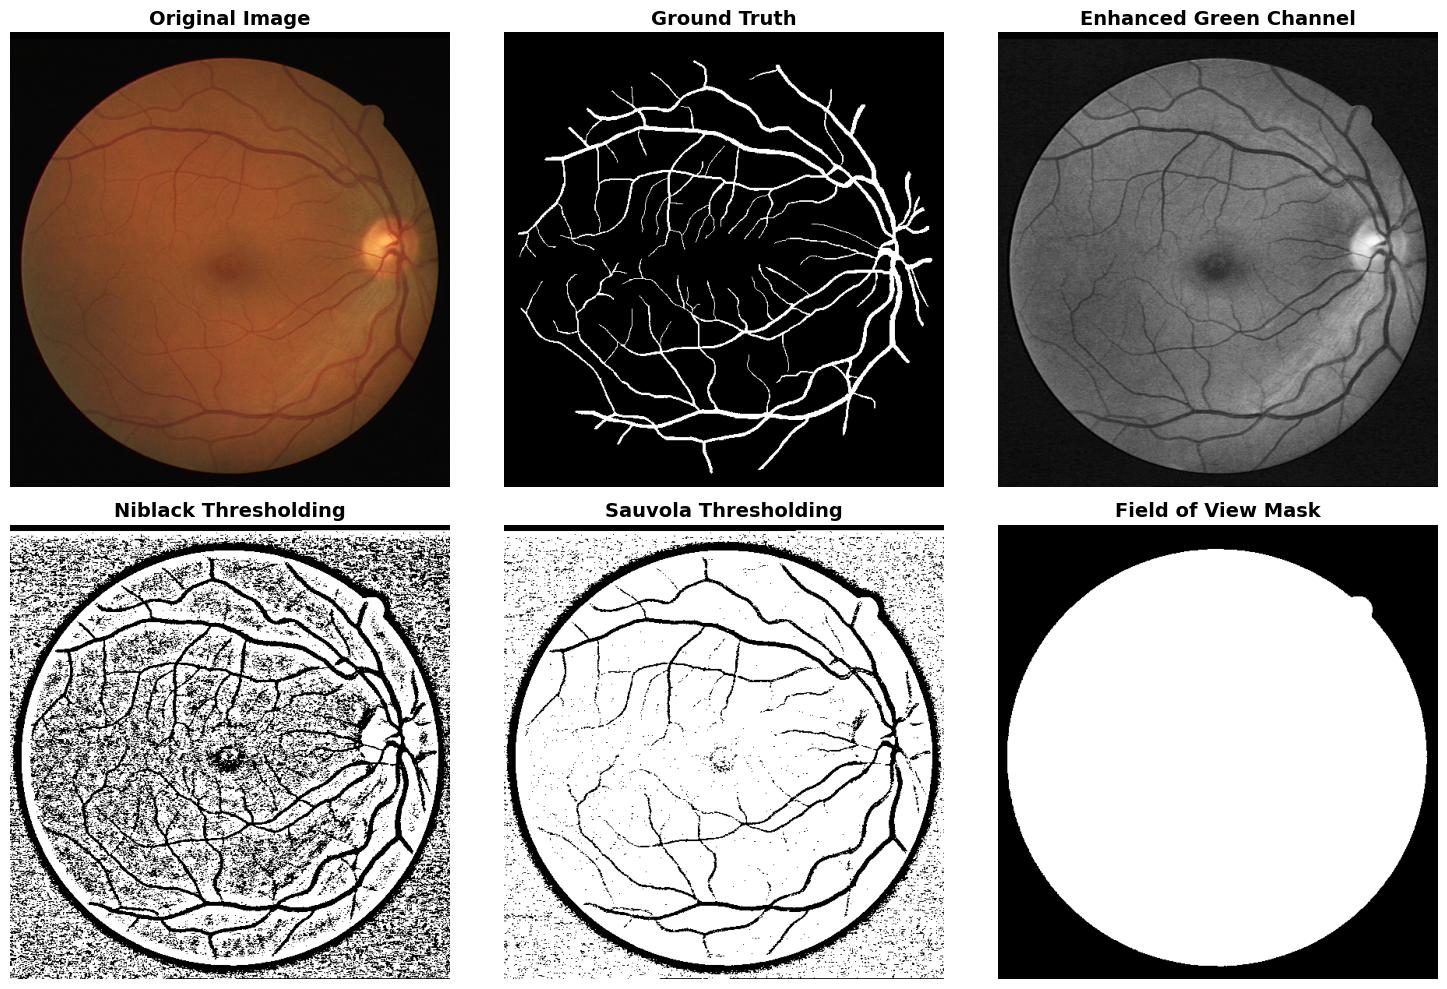

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.imshow(image)
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Ground Truth", fontsize=14, fontweight='bold')
plt.imshow(gt, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Enhanced Green Channel", fontsize=14, fontweight='bold')
plt.imshow(enhanced, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Niblack Thresholding", fontsize=14, fontweight='bold')
plt.imshow(binary_niblack, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Sauvola Thresholding", fontsize=14, fontweight='bold')
plt.imshow(binary_sauvola, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Field of View Mask", fontsize=14, fontweight='bold')
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

## 10. Compare Methods

Create a bar chart comparing the average performance of both methods.

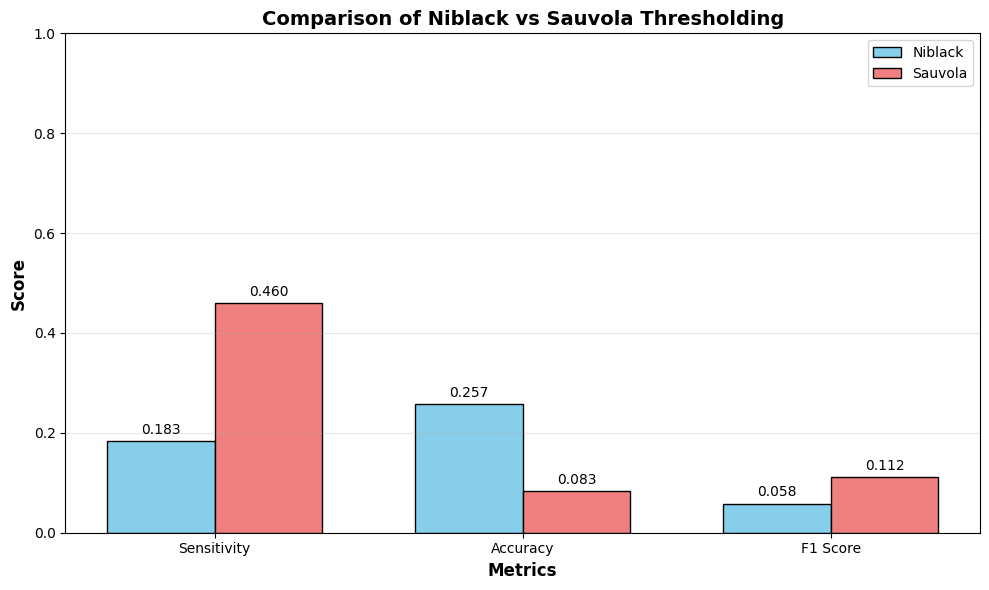

In [10]:
# Prepare data for comparison
metrics_names = ['Sensitivity', 'Accuracy', 'F1 Score']
niblack_avg = [np.mean(niblack_metrics[:, i]) for i in range(3)]
sauvola_avg = [np.mean(sauvola_metrics[:, i]) for i in range(3)]

# Create bar chart
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, niblack_avg, width, label='Niblack', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, sauvola_avg, width, label='Sauvola', color='lightcoral', edgecolor='black')

# Add labels and title
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Niblack vs Sauvola Thresholding', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

plt.tight_layout()
plt.show()